In [1]:
import numpy as np

data = np.load('moving-mnist-test.npz')
clips = data['clips']
dims = data['dims']
raw = data['input_raw_data']  # shape: (60000, 1, 64, 64)
input_length = 10

print(f"clips shape: {clips.shape}")
print(f"dims: {dims}")
print(f"raw data shape: {raw.shape}")


clips shape: (2, 3000, 2)
dims: [[ 1 64 64]]
raw data shape: (60000, 1, 64, 64)


In [2]:
print(data.files)

['clips', 'dims', 'input_raw_data']


# Set random pixels to 0

In [3]:
def corrupt_frames_randomly(frames, input_length, corruption_ratio=0.1):
    """
    Randomly zeroes out a percentage of pixels in each frame.

    frames: (N, H, W) numpy array
    input_length: int denoting the amount of frames that need to be corrupted for the input
    corruption_ratio: float in [0, 1]
    """
    corrupted = frames.copy()
    N, H, W = corrupted.shape
    num_pixels = H * W
    num_to_corrupt = int(num_pixels * corruption_ratio)

    for i in range(input_length):
        indices = np.random.choice(num_pixels, num_to_corrupt, replace=False)
        y_coords, x_coords = np.unravel_index(indices, (H, W))
        corrupted[i, y_coords, x_coords] = 0
    return corrupted

# Remove channel dimension: (60000, 64, 64)
frames = raw.squeeze(1)
corrupted_frames = corrupt_frames_randomly(frames, input_length, corruption_ratio=0.1)


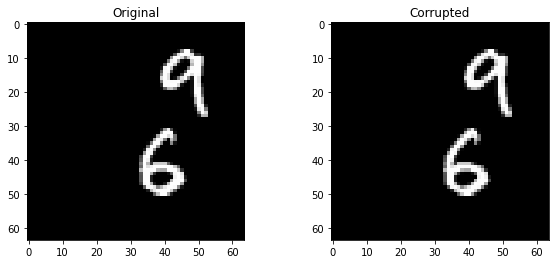

In [4]:
import matplotlib.pyplot as plt

i = 123  # any frame index

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(frames[i], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Corrupted")
plt.imshow(corrupted_frames[i], cmap='gray')

plt.show()


In [ ]:
# Load original to get 'clips' and 'dims'
original = np.load('moving-mnist-test.npz')
clips = original['clips']
dims = original['dims']

# Your corrupted data, assumed to be shape (60000, 64, 64)
# Add back the channel dimension to match original shape (60000, 1, 64, 64)
corrupted_raw = corrupted_frames[:, np.newaxis, :, :]

# Save in the same structure
np.savez_compressed(
    'moving-mnist-corrupted.npz',
    clips=clips,
    dims=dims,
    input_raw_data=corrupted_raw
)


# Set random rows to 0

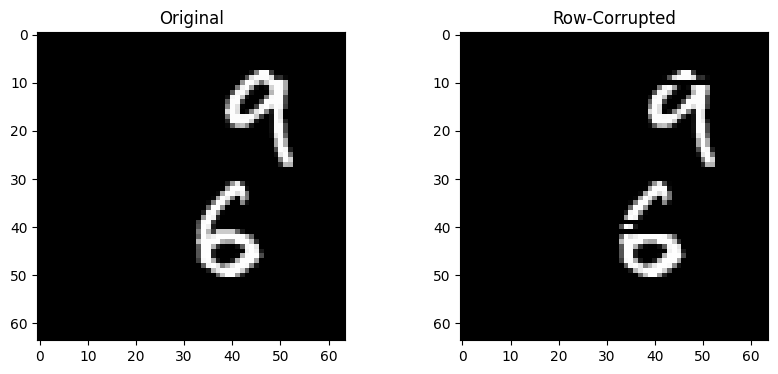

Original shape: (60000, 64, 64)
Corrupted shape: (60000, 64, 64)
Saved corrupted data with 6 rows zeroed per frame on average


In [4]:
def corrupt_frames_rows(frames, corruption_ratio=0.1):
    """
    Randomly zeroes out a percentage of rows in each frame.

    frames: (N, H, W) numpy array
    corruption_ratio: float in [0, 1] - percentage of rows to corrupt
    """
    corrupted = frames.copy()
    N, H, W = corrupted.shape
    num_rows_to_corrupt = int(H * corruption_ratio)

    for i in range(N):
        # Randomly select which rows to corrupt
        row_indices = np.random.choice(H, num_rows_to_corrupt, replace=False)
        # Zero out the selected rows
        corrupted[i, row_indices, :] = 0

    return corrupted

# Remove channel dimension: (60000, 64, 64)
frames = raw.squeeze(1)

# Apply row-based corruption
corrupted_frames = corrupt_frames_rows(frames, corruption_ratio=0.1)

# Visualize the difference
i = 123  # any frame index

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(frames[i], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Row-Corrupted")
plt.imshow(corrupted_frames[i], cmap='gray')

plt.show()

# Load original to get 'clips' and 'dims'
original = np.load('moving-mnist-test.npz')
clips = original['clips']
dims = original['dims']

# Add back the channel dimension to match original shape (60000, 1, 64, 64)
corrupted_raw = corrupted_frames[:, np.newaxis, :, :]

# Save in the same structure
np.savez_compressed(
    'moving-mnist-row-corrupted.npz',
    clips=clips,
    dims=dims,
    input_raw_data=corrupted_raw
)

print(f"Original shape: {frames.shape}")
print(f"Corrupted shape: {corrupted_frames.shape}")
print(f"Saved corrupted data with {int(64 * 0.1)} rows zeroed per frame on average")

# set random blocks to 0

# size 2x2

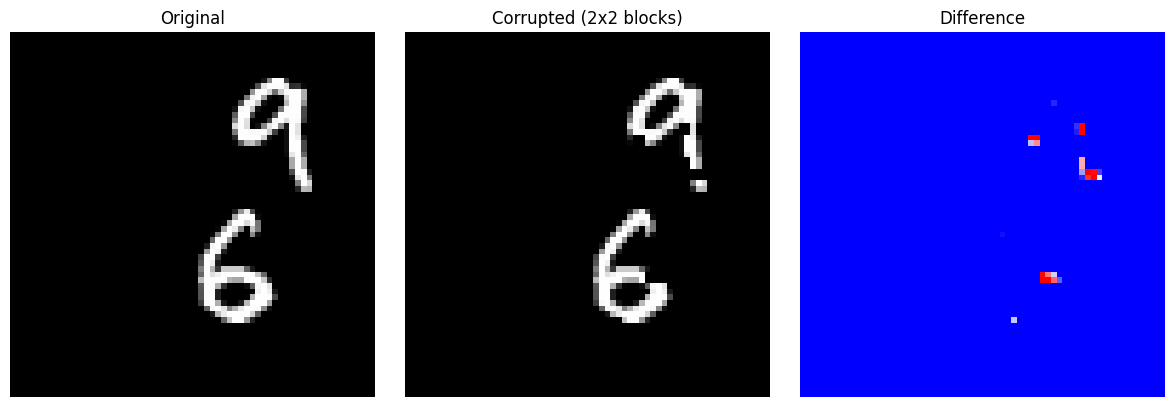

Original shape: (60000, 64, 64)
Corrupted shape: (60000, 64, 64)
Saved corrupted dataset with 2x2 block corruption to 'moving-mnist-corrupted-blocks.npz'


In [17]:
def corrupt_frames_with_blocks(frames, corruption_ratio=0.1, block_size=10):
    """
    Randomly zeroes out blocks of pixels in each frame.

    frames: (N, H, W) numpy array
    corruption_ratio: float in [0, 1] - fraction of total area to corrupt
    block_size: int - size of square blocks to corrupt (default 2 for 2x2 blocks)
    """
    corrupted = frames.copy()
    N, H, W = corrupted.shape

    # Calculate how many blocks we can fit in each dimension
    blocks_per_row = H // block_size
    blocks_per_col = W // block_size
    total_blocks = blocks_per_row * blocks_per_col

    # Calculate how many blocks to corrupt based on the corruption ratio
    # Each block covers block_size^2 pixels
    total_pixels = H * W
    pixels_to_corrupt = int(total_pixels * corruption_ratio)
    blocks_to_corrupt = max(1, pixels_to_corrupt // (block_size * block_size))

    # Make sure we don't try to corrupt more blocks than available
    blocks_to_corrupt = min(blocks_to_corrupt, total_blocks)

    for i in range(N):
        # Generate random block positions
        block_indices = np.random.choice(total_blocks, blocks_to_corrupt, replace=False)

        for block_idx in block_indices:
            # Convert block index to row, col coordinates
            block_row = (block_idx // blocks_per_col) * block_size
            block_col = (block_idx % blocks_per_col) * block_size

            # Zero out the block
            corrupted[i, block_row:block_row+block_size, block_col:block_col+block_size] = 0

    return corrupted

# Remove channel dimension: (60000, 64, 64)
frames = raw.squeeze(1)

# Apply block corruption
corrupted_frames = corrupt_frames_with_blocks(frames, corruption_ratio=0.1, block_size=2)

# Visualize the difference
i = 123  # any frame index

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(frames[i], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Corrupted (2x2 blocks)")
plt.imshow(corrupted_frames[i], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Difference")
plt.imshow(frames[i] - corrupted_frames[i], cmap='bwr')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the corrupted dataset
# Load original to get 'clips' and 'dims'
clips = data['clips']
dims = data['dims']

# Add back the channel dimension to match original shape (60000, 1, 64, 64)
corrupted_raw = corrupted_frames[:, np.newaxis, :, :]

# Save in the same structure
np.savez_compressed(
    'moving-mnist-corrupted-blocks_22.npz',
    clips=clips,
    dims=dims,
    input_raw_data=corrupted_raw
)

print(f"Original shape: {frames.shape}")
print(f"Corrupted shape: {corrupted_frames.shape}")

# size 5

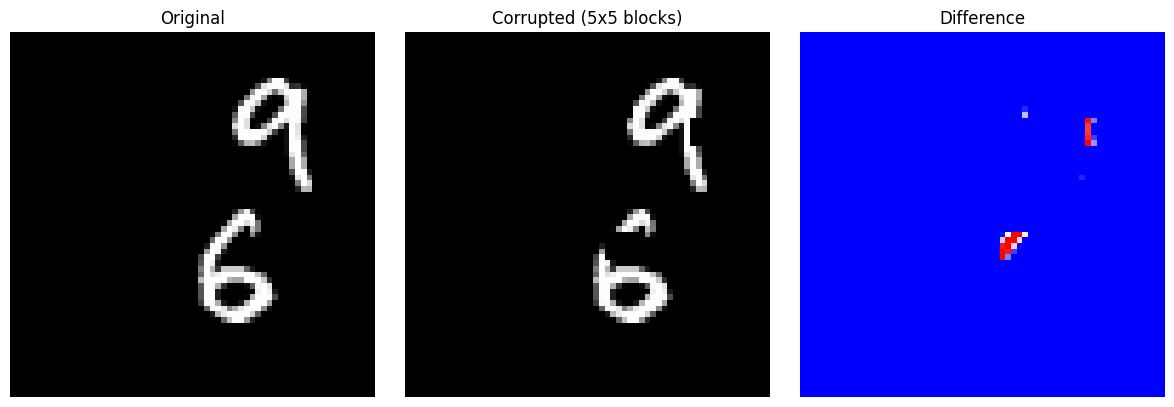

Original shape: (60000, 64, 64)
Corrupted shape: (60000, 64, 64)


In [19]:
# Remove channel dimension: (60000, 64, 64)
frames = raw.squeeze(1)

# Apply block corruption
corrupted_frames = corrupt_frames_with_blocks(frames, corruption_ratio=0.1, block_size=5)

# Visualize the difference
i = 123  # any frame index

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(frames[i], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Corrupted (5x5 blocks)")
plt.imshow(corrupted_frames[i], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Difference")
plt.imshow(frames[i] - corrupted_frames[i], cmap='bwr')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the corrupted dataset
# Load original to get 'clips' and 'dims'
clips = data['clips']
dims = data['dims']

# Add back the channel dimension to match original shape (60000, 1, 64, 64)
corrupted_raw = corrupted_frames[:, np.newaxis, :, :]

# Save in the same structure
np.savez_compressed(
    'moving-mnist-corrupted-blocks_55.npz',
    clips=clips,
    dims=dims,
    input_raw_data=corrupted_raw
)

print(f"Original shape: {frames.shape}")
print(f"Corrupted shape: {corrupted_frames.shape}")

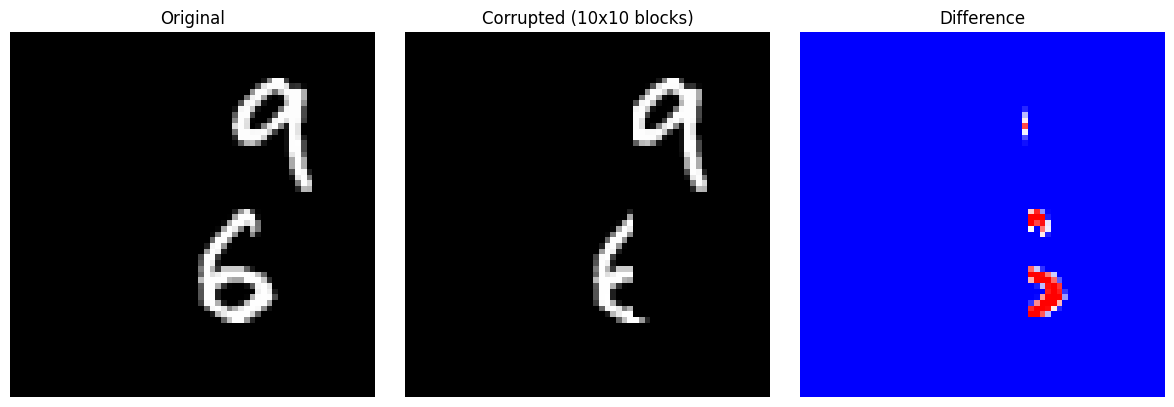

Original shape: (60000, 64, 64)
Corrupted shape: (60000, 64, 64)
Saved corrupted dataset with 10x10 block corruption to 'moving-mnist-corrupted-blocks.npz'


In [18]:
# Remove channel dimension: (60000, 64, 64)
frames = raw.squeeze(1)

# Apply block corruption
corrupted_frames = corrupt_frames_with_blocks(frames, corruption_ratio=0.1, block_size=10)

# Visualize the difference
i = 123  # any frame index

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(frames[i], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Corrupted (10x10 blocks)")
plt.imshow(corrupted_frames[i], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Difference")
plt.imshow(frames[i] - corrupted_frames[i], cmap='bwr')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the corrupted dataset
# Load original to get 'clips' and 'dims'
clips = data['clips']
dims = data['dims']

# Add back the channel dimension to match original shape (60000, 1, 64, 64)
corrupted_raw = corrupted_frames[:, np.newaxis, :, :]

# Save in the same structure
np.savez_compressed(
    'moving-mnist-corrupted-blocks_1010.npz',
    clips=clips,
    dims=dims,
    input_raw_data=corrupted_raw
)

print(f"Original shape: {frames.shape}")
print(f"Corrupted shape: {corrupted_frames.shape}")